In [1]:
import pandas as pd
import numpy as np
import torch
import utils.print as print_f
import os

from utils.engine import evaluate, get_iou_types
from utils.plot import plot_losses, plot_ap_ars

from models.utils import get_model_size_in_MB
from models.build import create_model_from_setup
from models.setup import ModelSetup
from models.train import TrainingInfo
from utils.save import check_best, end_train, get_data_from_metric_logger
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_ap_ar, get_ap_ar_for_train_val
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss
from utils.init import reproducibility, clean_memory_get_device
from data.paths import MIMIC_EYE_PATH
# from datetime import datetime
# from models.dynamic_loss import DynamicWeightedLoss
from utils.engine import train_one_epoch, evaluate
from torch import optim
from data.paths import MIMIC_EYE_PATH
from models.load import get_trained_model
# from data.load import seed_worker, get_dataloader_g


## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
from enum import Enum

class TrainedModels(Enum):
    continue_training = "val_lesion-detection_ap_0_1226_test_lesion-detection_ap_0_1372_epoch30_03-09-2023 11-58-37_chexpert_without_fix"


In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
get_epoch_from_model = lambda select_model: int(([substr for substr in select_model.value.split("_") if "epoch" in substr][0]).replace("epoch", ""))
get_model_name = lambda select_model: str(select_model).split(".")[-1]

In [5]:
train_more_models = [
    TrainedModels.continue_training
]

target_epoch = 50

# need to create a list for storing the namimg.
train_infos = []

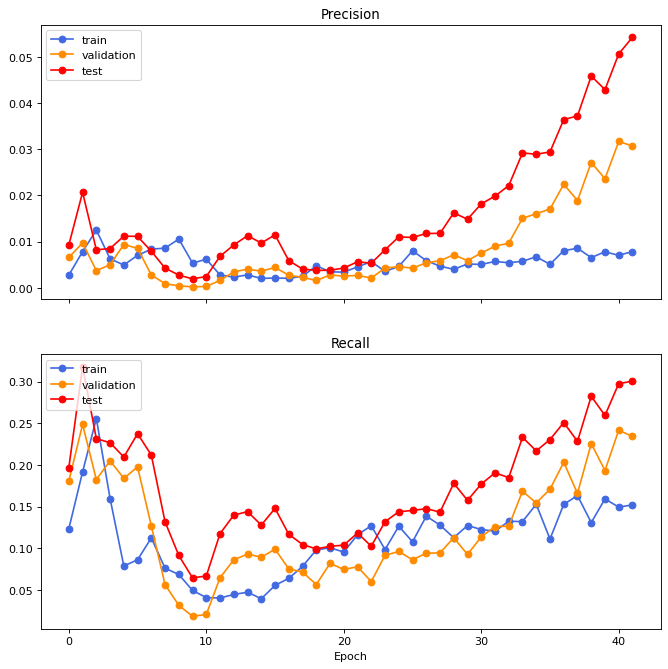

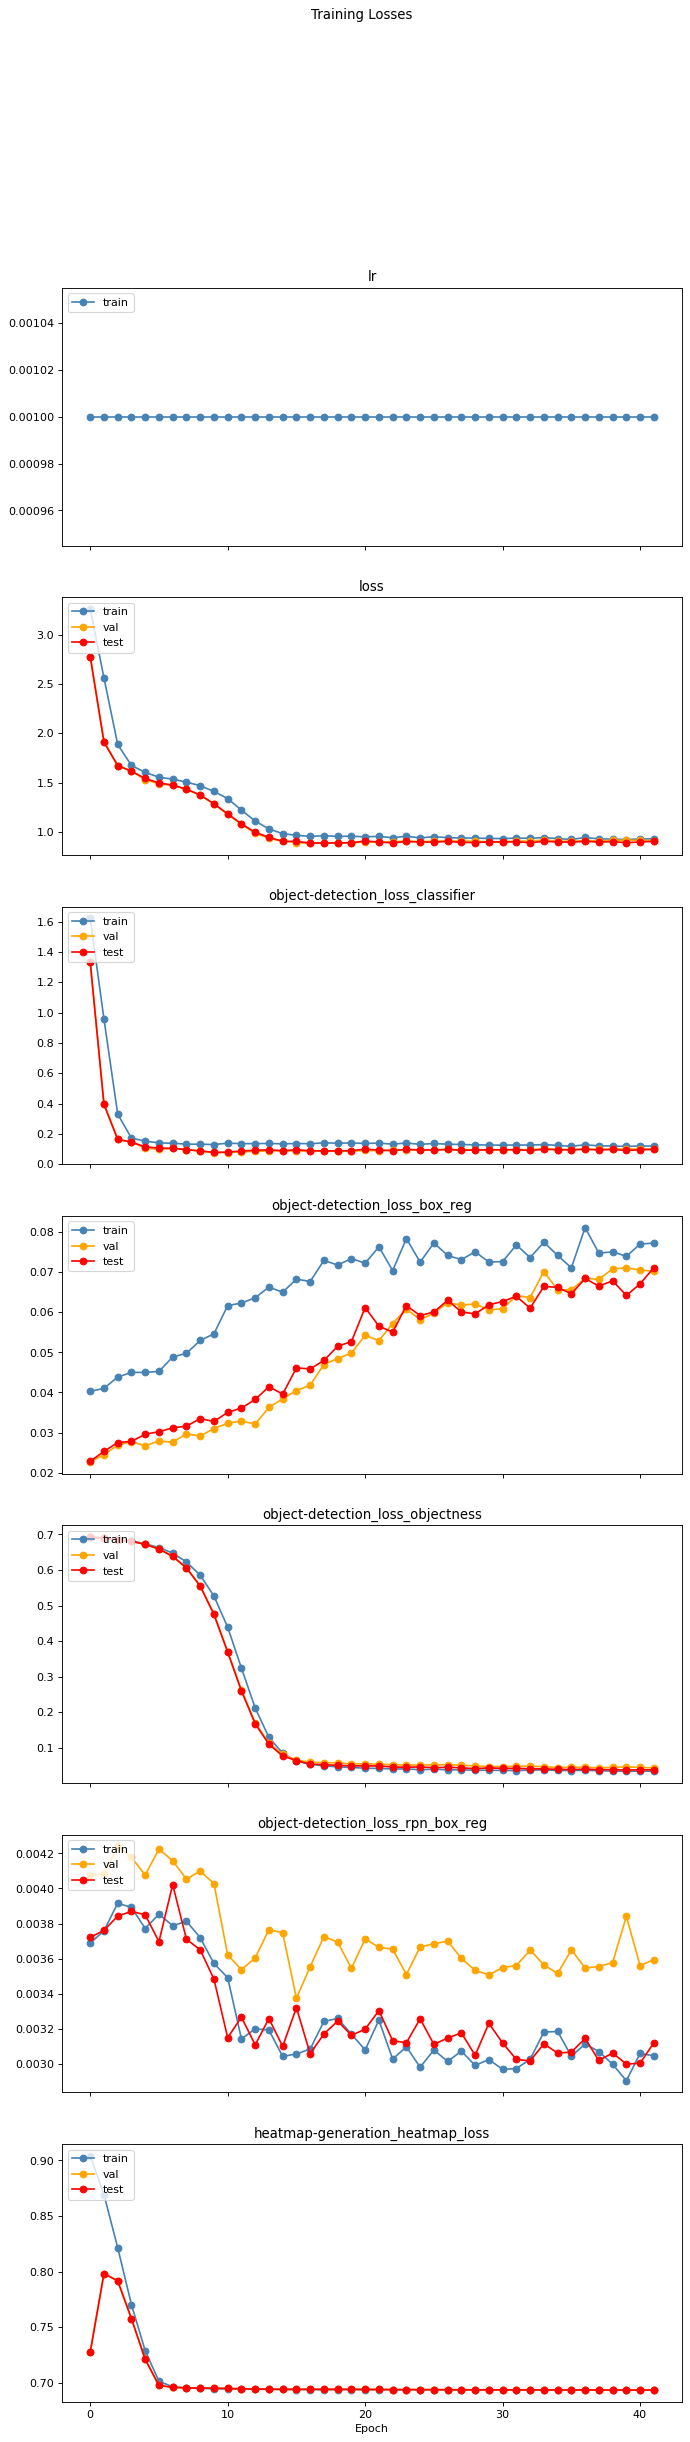

====================| Epoch [42] Done | It has took [99.87] min, Avg time: [142.67] sec/epoch | Estimate time for [20] epochs: [47.56] min | Epoch took [430] sec | Patience [11] |====================
====================Training model: [basline_test]====================
========================================For Training [basline_test]========================================
ModelSetup(name='basline_test', sources=['image'], tasks=['object-detection', 'heatmap-generation'], decoder_channels=[128, 64, 32, 16, 1], label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, record_training_performance=True, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=1e-05, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, backbone_out_channels=64, batch_size=32, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patien

KeyboardInterrupt: 

In [6]:
# we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.
for select_model in train_more_models:
    
    model, train_info, optimizer, dynamic_loss_weight = get_trained_model(
        select_model,
        device,
    )
    model = model.to(device)
    model.train()

    setup = train_info.model_setup

    print(f" Model Size [{get_model_size_in_MB(model):.3f}] MB")
    
    ################ Datasets ################
    dataset_params_dict = {
        "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
        "with_fixations": "heatmap-generation" in setup.tasks,
        "bbox_to_mask": False,
        "labels_cols": setup.label_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=setup.batch_size,
    )

    train_coco = None
    train_coco, val_coco, test_coco, eval_params_dict = get_coco_eval_params(
        train_dataloader,
        val_dataloader,
        test_dataloader,
        detect_eval_dataset,
        setup.iou_thrs,
        setup.use_iobb,
    )

    params = model.get_all_params(dynamic_loss_weight=dynamic_loss_weight)

    iou_types = get_iou_types(model, setup)
    optimizer = get_optimiser(params, setup)
    lr_scheduler = get_lr_scheduler(optimizer, setup)

    last_trainng_epoch = train_info.epoch
    num_epochs_to_run = target_epoch - last_trainng_epoch

    train_info.timer.start_training()

    val_loss = None

    # Start the training from here.
    for e in range(last_trainng_epoch+1, target_epoch+1):

        print_f.print_title(f"Training model: [{setup.name}]")

        print(train_info)

        train_info.epoch = e

        train_info.timer.start_epoch()

        if train_info.epoch > setup.gt_in_train_till:
            model.roi_heads.use_gt_in_train = False

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = train_one_epoch(
            setup=setup,
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            # data_loader=test_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            score_thres=None,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_losses.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = evaluate(
            setup=setup,
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            score_thres=None,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_losses.append(get_data_from_metric_logger(val_logger))

        train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
            train_info.last_train_evaluator,
            train_info.last_val_evaluator,
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        train_info.train_ap_ars.append(train_ap_ar)
        train_info.val_ap_ars.append(val_ap_ar)

        if setup.measure_test:
            train_info.test_evaluator, test_logger = evaluate(
                setup=setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
            )
            train_info.test_losses.append(get_data_from_metric_logger(test_logger))
            test_ap_ar = get_ap_ar(
                train_info.test_evaluator, areaRng="all", iouThr=0.5, maxDets=10,
            )
            train_info.test_ap_ars.append(test_ap_ar)

        # update the learning rate

        val_loss = train_info.val_losses[-1]["loss"]

        epoch_took, sec_already_took, speed = train_info.timer.end_epoch(train_info.epoch)

        if train_info.epoch > setup.warmup_epochs:
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    if (
                        setup.reduceLROnPlateau_full_stop
                        and lr_scheduler.num_bad_epochs
                        >= setup.reduceLROnPlateau_patience
                    ):
                        print_f.print_title(
                            f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs_to_run}] epochs: [{speed*num_epochs_to_run/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
                        )
                        break
                    lr_scheduler.step(val_loss)
                else:
                    lr_scheduler.step()

        # Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        plot_ap_ars(
            train_ap_ars=train_info.train_ap_ars,
            val_ap_ars=train_info.val_ap_ars,
            test_ap_ars=train_info.test_ap_ars,
        )

        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
            test_logers=train_info.test_losses,
        )

        # previous_time = current_time
        # current_time = datetime.now()
        # epoch_took = current_time - previous_time

        # sec_took = (current_time - train_info.start_t).seconds
        # speed = sec_took / train_info.epoch

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs_to_run}] epochs: [{speed*num_epochs_to_run/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs"):
            print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(print_str)

        #######################################################################################
        if setup.save_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                setup=setup,
                val_ap_ar=val_ap_ar,
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
                dynamic_weight=dynamic_loss_weight,
            )

    val_ap_ar = get_ap_ar(train_info.last_val_evaluator)

    train_info = end_train(
        setup=setup,
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ap_ar["ar"],
        last_val_ap=val_ap_ar["ap"],
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
        dynamic_weight=dynamic_loss_weight,
    )

    train_infos.append(train_info)


In [ ]:
for train_info in train_infos:
    print(train_info)
    model_setup: ModelSetup = train_info.model_setup
    model = create_model_from_setup(
        model_setup
    )
    
    print_params_setup(model)

    print(
        f"Max AP on test: [{max([ap_ar['ap']  for ap_ar in  train_info.test_ap_ars]):.4f}]"
    )
    plot_ap_ars(
        train_ap_ars=train_info.train_ap_ars,
        val_ap_ars=train_info.val_ap_ars,
        test_ap_ars=train_info.test_ap_ars,
    )

    plot_losses(
        train_info.train_losses,
        train_info.val_losses,
        test_logers=train_info.test_losses,
    )

